# Chapter 4: Testing and regularization with Turi Create

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(0)

## Defining our dataset

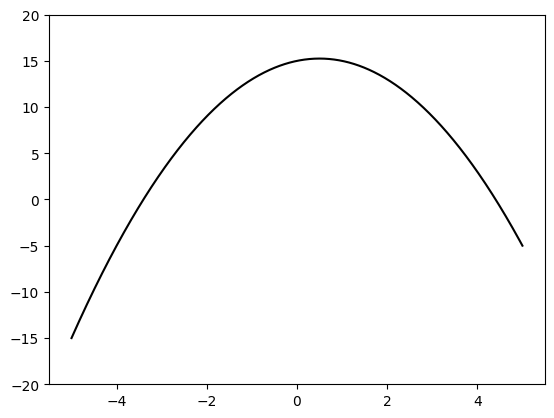

In [2]:
# Our original polynomial is -x^2+x+15
coefs = [15,1,-1]

def polynomial(coefs, x):
    n = len(coefs)
    return sum([coefs[i]*x**i for i in range(n)])

def draw_polynomial(coefs):
    n = len(coefs)
    x = np.linspace(-5, 5, 1000)
    plt.ylim(-20,20)
    plt.plot(x, sum([coefs[i]*x**i for i in range(n)]), linestyle='-', color='black')

draw_polynomial(coefs)

In [3]:
X = []
Y = []
for i in range(50):
    x = random.uniform(-5,5)
    
    
    y = polynomial(coefs, x) + random.gauss(0,2)
    X.append(x)
    Y.append(y)

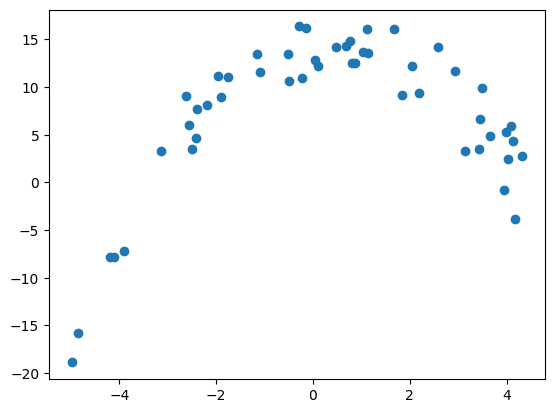

In [4]:
plt.scatter(X, Y)
#draw_polynomial(coefs)

## Training a polynomial regression model

In [5]:
import turicreate as tc

In [6]:
data = tc.SFrame({'x':X, 'y':Y})
data 

x,y
3.4442185152504816,6.685961311021467
-2.4108324970703663,4.690236225597948
0.11274721368608542,12.205789026637378
-1.9668727392107255,11.133217991032268
-0.23403045847644144,10.927272159051856
0.046868558173902564,12.8584762866286
-2.1816215560029617,8.16012255928749
-2.4949365863755943,3.5061587527226514
4.097462559682402,5.933186396721837
4.021659504395828,2.454299054753137


### Adding columns to our dataset corresponding to $x^2, x^3, \ldots, x^{200}$

In [7]:
features = ['x']
for i in range(2,200):
    string = 'x^'+str(i)
    features.append(string)
    #data[string] = data['x'].apply(lambda x:x**i)
    data[string] = data['x']**i
#data
data.print_rows(num_rows=10, num_columns=20)

+----------------------+--------------------+----------------------+
|          x           |         y          |         x^2          |
+----------------------+--------------------+----------------------+
|  3.4442185152504816  | 6.685961311021467  |  11.862641180794233  |
| -2.4108324970703663  | 4.690236225597948  |  5.812113328930538   |
| 0.11274721368608542  | 12.205789026637378 | 0.012711934193975809 |
| -1.9668727392107255  | 11.133217991032268 |  3.8685883722503025  |
| -0.23403045847644144 | 10.927272159051856 | 0.05477025549469338  |
| 0.046868558173902564 |  12.8584762866286  | 0.002196661745300489 |
| -2.1816215560029617  |  8.16012255928749  |  4.759472613616784   |
| -2.4949365863755943  | 3.5061587527226514 |  6.224708570035504   |
|  4.097462559682402   | 5.933186396721837  |  16.789199427999062  |
|  4.021659504395828   | 2.454299054753137  |  16.173745169297295  |
+----------------------+--------------------+----------------------+
+-----------------------+---------

## Splitting data into training and testing

In [8]:
train, test = data.random_split(.8, seed=0)

In [9]:
def display_results(model):
    coefs = model.coefficients
    print"Training error (rmse):", model.evaluate(train)['rmse'])
    print("Testing error (rmse):", model.evaluate(test)['rmse'])
    plt.scatter(train['x'], train['y'], marker='o')
    plt.scatter(test['x'], test['y'], marker='^')
    draw_polynomial(coefs['value'])
    plt.show()
    print("Polynomial coefficients")
    print(coefs['name', 'value'])

## Training a polynomial regression model with no regularization

In [10]:
model_no_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.0, l2_penalty=0.0, verbose=False, validation_set=None)

Training error (rmse): 1.3356355716979242
Testing error (rmse): 4.720689327740325


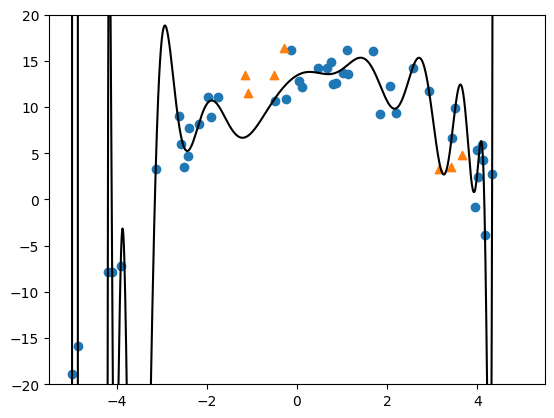

Polynomial coefficients
+-------------+---------------------+
|     name    |        value        |
+-------------+---------------------+
| (intercept) |  13.422714690808789 |
|      x      |  2.816882808052146  |
|     x^2     |  -5.227677430299636 |
|     x^3     | -0.6203375018587952 |
|     x^4     |  2.312888925300005  |
|     x^5     |  3.142314367727882  |
|     x^6     |  0.6300603086122968 |
|     x^7     |  -2.61255631776183  |
|     x^8     | -0.5761567308438644 |
|     x^9     |  0.7726266452815371 |
+-------------+---------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [11]:
display_results(model_no_reg)

In [12]:
degree = [i for i in range(1, 11)]
print(degree)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


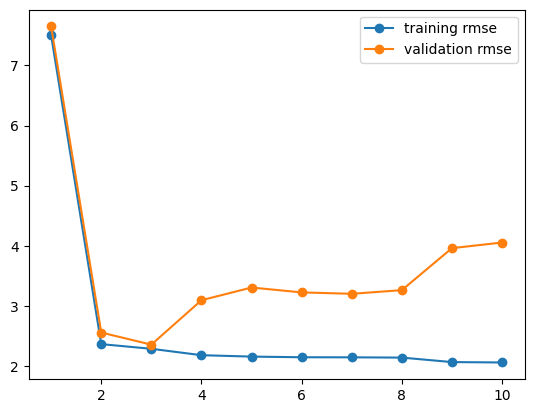

In [13]:
train_error = []
val_error = []
for n in range(1, 11):
    model = tc.linear_regression.create(
        train, target='y', l1_penalty=0.0, l2_penalty=0.0, verbose=False,
        validation_set=None, features = features[0:n])
    train_error.append(model.evaluate(train)['rmse'])
    val_error.append(model.evaluate(test)['rmse'])
    
plt.plot(degree, train_error, marker='o')
plt.plot(degree, val_error, marker='o')
plt.legend(['training rmse', 'validation rmse'])
plt.show()

## Training a polynomial regression model with L1 regularization

In [14]:
#model_L1_reg = tc.linear_regression.create(train, target='y', l1_penalty=0.1, l2_penalty=0.0, verbose=False, validation_set=None, features = features)
model_L1_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.1, l2_penalty=0.0, verbose=False, validation_set=None)

Training error (rmse): 9.3779204367541
Testing error (rmse): 10.080162123989725


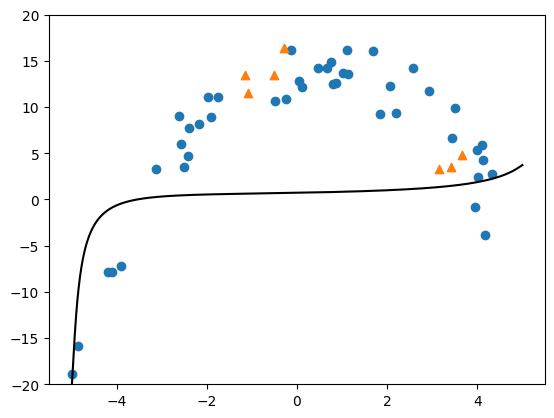

Polynomial coefficients
+-------------+-------------------------+
|     name    |          value          |
+-------------+-------------------------+
| (intercept) |    0.7237925811235593   |
|      x      |   0.09118542912855322   |
|     x^2     |   0.01235706554478867   |
|     x^3     |   0.004654502140516864  |
|     x^4     | -0.00010725390587743669 |
|     x^5     |  0.00021760544685171115 |
|     x^6     |  -1.794453274770147e-05 |
|     x^7     |  9.013165900085546e-06  |
|     x^8     | -1.0066364743269786e-06 |
|     x^9     |  3.4679918642564075e-07 |
+-------------+-------------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [15]:
display_results(model_L1_reg)

## Training a polynomial regression model with L2 regularization

In [16]:
model_L2_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.0, l2_penalty=0.1, verbose=False, validation_set=None)

Training error (rmse): 2.103771083491511
Testing error (rmse): 3.3843510223345423


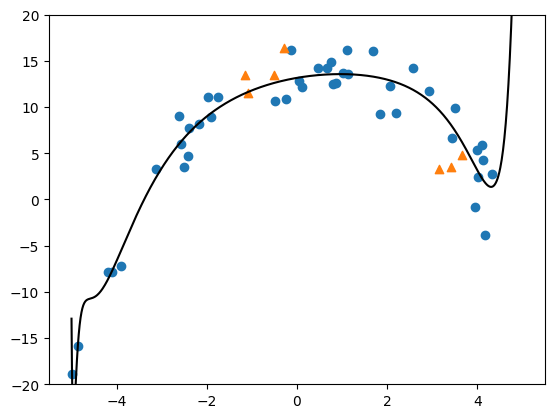

Polynomial coefficients
+-------------+-------------------------+
|     name    |          value          |
+-------------+-------------------------+
| (intercept) |    13.162465256037835   |
|      x      |    0.8428535825881361   |
|     x^2     |   -0.45488038686563126  |
|     x^3     |   0.036952802602799414  |
|     x^4     |  -0.019506339435392542  |
|     x^5     |  0.0004901125603828199  |
|     x^6     |  -0.0007049896336172732 |
|     x^7     | -4.2095363412537506e-05 |
|     x^8     |  -1.612462959774717e-05 |
|     x^9     | -2.2774247599736416e-06 |
+-------------+-------------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [17]:
display_results(model_L2_reg)

## Viewing the predictions in the testing set

In [18]:
predictions = test['x', 'y']
predictions['No reg'] = model_no_reg.predict(test)
predictions['L1 reg'] = model_L1_reg.predict(test)
predictions['L2 reg'] = model_L2_reg.predict(test)

In [19]:
predictions

x,y,No reg,L1 reg,L2 reg
-0.2785728454728664,16.36505651355184,12.25499890989703,0.6992480981423739,12.891451664732534
3.6530992777164,4.83366913200435,12.236859232860297,1.6129197287600443,6.2689973721717385
-0.5203042856442961,13.47860807272069,10.71338345462332,0.6790214503340304,12.594114398228696
3.14466863291336,3.2664703661537313,4.311106327037123,1.3436400523380332,9.697061424742522
-1.1509885402733957,13.436894195835206,6.724334890037007,0.6274141062843831,11.496598949669675
3.424602231401824,3.5269925176080537,6.450340564493672,1.4780916731652867,8.015593834294965
-1.087039497653751,11.572117170027912,6.886777351815456,0.6327648062020981,11.632177542991773


In [1]:
def display_coefficients(model):
    coefs = model.coefficients
    intercept = coefs['value'][0]  # First coefficient (intercept)
    slope = coefs['value'][1]       # Second coefficient (slope for x)
    
    print(f"Intercept: {intercept}")
    print(f"Slope: {slope}")

# Display coefficients for each model
print("No Regularization Model:")
display_coefficients(model_no_reg)

print("\nL1 Regularization Model:")
display_coefficients(model_L1_reg)

print("\nL2 Regularization Model:")
display_coefficients(model_L2_reg)


No Regularization Model:


NameError: name 'model_no_reg' is not defined

/tmp/ipykernel_562/99061182.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[string] = data['x'] ** i
/tmp/ipykernel_562/99061182.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[string] = data['x'] ** i
/tmp/ipykernel_562/99061182.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


          x          y        x^2        x^3         x^4         x^5  \
0  3.444219   6.685961  11.862641  40.857528  140.722256  484.678199   
1 -2.410832   4.690236   5.812113 -14.012032   33.780661  -81.439516   
2  0.112747  12.205789   0.012712   0.001433    0.000162    0.000018   
3 -1.966873  11.133218   3.868588  -7.609021   14.965976  -29.436170   
4 -0.234030  10.927272   0.054770  -0.012818    0.003000   -0.000702   

           x^6           x^7           x^8           x^9  ...          x^190  \
0  1669.337627  5.749564e+03  1.980275e+04  6.820501e+04  ...  1.114891e+102   
1   196.337032 -4.733357e+02  1.141133e+03 -2.751081e+03  ...   4.090129e+72   
2     0.000002  2.316012e-07  2.611239e-08  2.944099e-09  ...  7.945211e-181   
3    57.897201 -1.138764e+02  2.239804e+02 -4.405410e+02  ...   6.568854e+55   
4     0.000164 -3.845092e-05  8.998685e-06 -2.105966e-06  ...  1.451285e-120   

           x^191          x^192          x^193          x^194          x^195  \
0  3.8

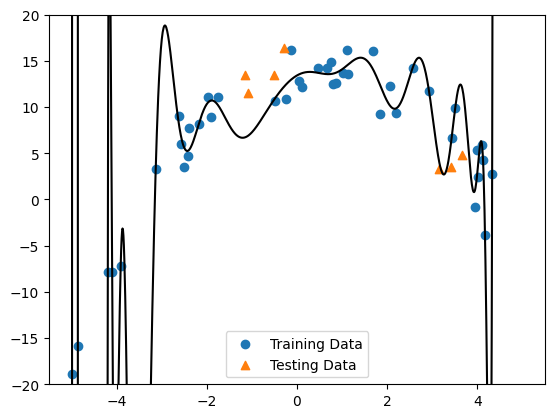

Polynomial coefficients:
+-------------+---------------------+
|     name    |        value        |
+-------------+---------------------+
| (intercept) |  13.422714690808789 |
|      x      |  2.816882808052146  |
|     x^2     |  -5.227677430299636 |
|     x^3     | -0.6203375018587952 |
|     x^4     |  2.312888925300005  |
|     x^5     |  3.142314367727882  |
|     x^6     |  0.6300603086122968 |
|     x^7     |  -2.61255631776183  |
|     x^8     | -0.5761567308438644 |
|     x^9     |  0.7726266452815371 |
+-------------+---------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
Training error (rmse): 9.3779204367541
Testing error (rmse): 10.080162123989725


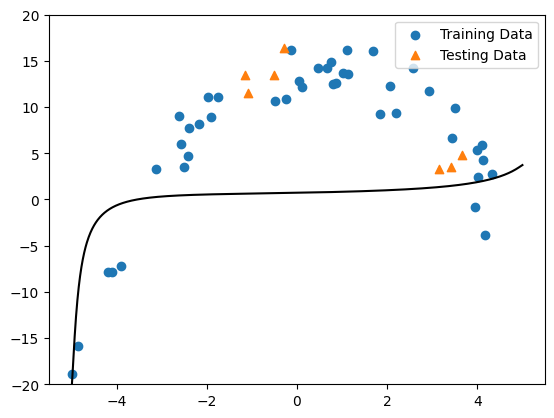

Polynomial coefficients:
+-------------+-------------------------+
|     name    |          value          |
+-------------+-------------------------+
| (intercept) |    0.7237925811235593   |
|      x      |   0.09118542912855322   |
|     x^2     |   0.01235706554478867   |
|     x^3     |   0.004654502140516864  |
|     x^4     | -0.00010725390587743669 |
|     x^5     |  0.00021760544685171115 |
|     x^6     |  -1.794453274770147e-05 |
|     x^7     |  9.013165900085546e-06  |
|     x^8     | -1.0066364743269786e-06 |
|     x^9     |  3.4679918642564075e-07 |
+-------------+-------------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
Training error (rmse): 2.103771083491511
Testing error (rmse): 3.3843510223345423


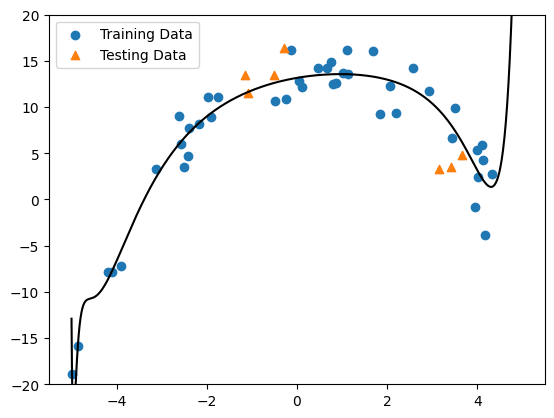

Polynomial coefficients:
+-------------+-------------------------+
|     name    |          value          |
+-------------+-------------------------+
| (intercept) |    13.162465256037835   |
|      x      |    0.8428535825881361   |
|     x^2     |   -0.45488038686563126  |
|     x^3     |   0.036952802602799414  |
|     x^4     |  -0.019506339435392542  |
|     x^5     |  0.0004901125603828199  |
|     x^6     |  -0.0007049896336172732 |
|     x^7     | -4.2095363412537506e-05 |
|     x^8     |  -1.612462959774717e-05 |
|     x^9     | -2.2774247599736416e-06 |
+-------------+-------------------------+
[200 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.
No Regularization Model:
Intercept: 13.422714690808789
Slope: 2.816882808052146

L1 Regularization Model:
Intercept: 0.7237925811235593
Slope: 0.09118542912855322

L2 Regularization Model:
Intercept: 13.162465256037835
Slope: 0.84285358

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import turicreate as tc

# Set random seed for reproducibility
random.seed(0)

# Original polynomial: -x^2 + x + 15
coefs = [15, 1, -1]

# Polynomial function definition
def polynomial(coefs, x):
    n = len(coefs)
    return sum([coefs[i] * x ** i for i in range(n)])

# Draw the polynomial
def draw_polynomial(coefs):
    n = len(coefs)
    x = np.linspace(-5, 5, 1000)
    plt.ylim(-20, 20)
    plt.plot(x, sum([coefs[i] * x ** i for i in range(n)]), linestyle='-', color='black')

# Generate data
X = []
Y = []
for i in range(50):
    x = random.uniform(-5, 5)
    y = polynomial(coefs, x) + random.gauss(0, 2)  # Add noise
    X.append(x)
    Y.append(y)

# Create a DataFrame from the generated data
data = pd.DataFrame({'x': X, 'y': Y})

# Create polynomial features
features = ['x']
for i in range(2, 200):
    string = f'x^{i}'
    features.append(string)
    data[string] = data['x'] ** i

# Display the first few rows of the DataFrame
print(data.head())

# Split the data into training and testing sets
train, test = tc.SFrame(data).random_split(0.8, seed=0)

# Function to display model results
def display_results(model):
    coefs = model.coefficients
    print("Training error (rmse):", model.evaluate(train)['rmse'])
    print("Testing error (rmse):", model.evaluate(test)['rmse'])
    plt.scatter(train['x'], train['y'], marker='o', label='Training Data')
    plt.scatter(test['x'], test['y'], marker='^', label='Testing Data')
    draw_polynomial(coefs['value'])
    plt.legend()
    plt.show()
    print("Polynomial coefficients:")
    print(coefs['name', 'value'])

# Train the model without regularization
model_no_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.0, l2_penalty=0.0, verbose=False, validation_set=None
)
display_results(model_no_reg)

# Train L1 regularization model
model_L1_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.1, l2_penalty=0.0, verbose=False, validation_set=None
)
display_results(model_L1_reg)

# Train L2 regularization model
model_L2_reg = tc.linear_regression.create(
    train, target='y', l1_penalty=0.0, l2_penalty=0.1, verbose=False, validation_set=None
)
display_results(model_L2_reg)

# Function to display coefficients
def display_coefficients(model):
    coefs = model.coefficients
    intercept = coefs['value'][0]  # First coefficient (intercept)
    slope = coefs['value'][1]       # Second coefficient (slope for x)
    
    print(f"Intercept: {intercept}")
    print(f"Slope: {slope}")

# Display coefficients for each model
print("No Regularization Model:")
display_coefficients(model_no_reg)

print("\nL1 Regularization Model:")
display_coefficients(model_L1_reg)

print("\nL2 Regularization Model:")
display_coefficients(model_L2_reg)
